# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 11.   


In [285]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:48:10.786781
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [286]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [287]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [288]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [289]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=11

all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 11 = SK.N.SH


## Data Load

In [290]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [291]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:48:15.241606
Load RCI values...
Num RCI: 9689
Example RCI: [('ENSG00000000003', 1.83443), ('ENSG00000000419', 2.1946), ('ENSG00000000457', -0.78064)]
Load genes...
2022-12-29 16:48:15.275492
Load sequence...
2022-12-29 16:48:24.473872
Num IDs: 5436
Example IDs: [('ENSG00000197530', 'ENST00000378708.5'), ('ENSG00000069424', 'ENST00000653262.1'), ('ENSG00000171680', 'ENST00000400915.8'), ('ENSG00000171608', 'ENST00000698716.1')]
Count 2157 ones out of 5436 labels.
Example labels: [0, 0, 0, 0]
Num counts: 5436
Example sequence: [33, 131, 10, 38, 151, 89, 97, 131, 11, 43, 171, 169, 163, 140, 46, 183, 219, 106, 167, 155, 106, 165, 146, 69, 17, 65, 1, 4, 15, 59, 234, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 168, 159, 123, 236, 175, 186, 232, 159, 122, 229, 147, 75, 43, 172, 174, 183, 219, 106, 165, 147, 74, 40, 158, 118, 214, 87, 90, 103, 155, 106, 165, 147, 74, 39, 155, 106, 166, 151, 91, 106, 167, 154, 102, 150, 86, 87, 91, 107

## Model

In [292]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [293]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:48:24.509789
COMPILE
Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_148 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_148 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_13  (None, 64)               0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_295 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [294]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:48:24.783717
2022-12-29 16:48:24.784958
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (4352, 3997) (4352, 1)
Valid sizes (1084, 3997) (1084, 1)
Train set ones/size 1705 / 4352
Valid set ones/size 452 / 1084
BUILD MODEL
COMPILE
FIT
2022-12-29 16:48:26.137028
Epoch 1/5
136/136 [==============================] - 2s 9ms/step - loss: 0.6177 - accuracy: 0.6367 - val_loss: 0.5303 - val_accuracy: 0.7140
Epoch 2/5
136/136 [==============================] - 1s 7ms/step - loss: 0.5421 - accuracy: 0.7206 - val_loss: 0.5254 - val_accuracy: 0.7196
Epoch 3/5
136/136 [==============================] - 1s 7ms/step - loss: 0.5383 - accuracy: 0.7289 - val_loss: 0.5249 - val_accuracy: 0.7232
Epoch 4/5
136/136 [==============================] - 1s 7ms/step - loss: 0.5362 - accuracy: 0.7286 - val_loss: 0.5170 - val_accuracy: 0.7279
Epoch 5/5
136/136 [==============================] - 1s 7ms/step - loss: 0.5337 - accuracy: 0.7259 - val_loss: 0.5176 - val_accuracy: 

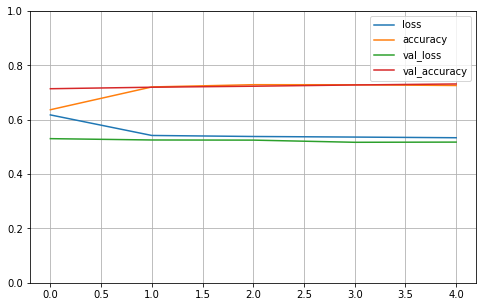

Compute valiation accuracy
2022-12-29 16:48:31.809369
Range of scores: 0.041187156 to 0.91408837
Predicted zeros and ones 667 417
Accuracy: 73.15% Precision: 69.30% Recall: 63.94% F1: 66.51%
2022-12-29 16:48:32.063633
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (4430, 3997) (4430, 1)
Valid sizes (1006, 3997) (1006, 1)
Train set ones/size 1727 / 4430
Valid set ones/size 430 / 1006
BUILD MODEL
COMPILE
FIT
2022-12-29 16:48:33.371661
Epoch 1/5
139/139 [==============================] - 2s 9ms/step - loss: 0.6073 - accuracy: 0.6553 - val_loss: 0.5576 - val_accuracy: 0.6988
Epoch 2/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5349 - accuracy: 0.7262 - val_loss: 0.5584 - val_accuracy: 0.7068
Epoch 3/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5295 - accuracy: 0.7336 - val_loss: 0.5579 - val_accuracy: 0.7068
Epoch 4/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5266 - accuracy: 0.7332 - val_loss: 0.5595 - v

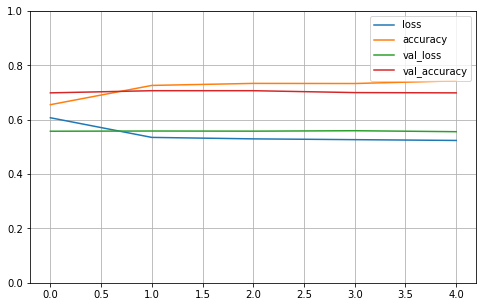

Compute valiation accuracy
2022-12-29 16:48:39.436797
Range of scores: 0.00840823 to 0.9009244
Predicted zeros and ones 615 391
Accuracy: 69.88% Precision: 66.24% Recall: 60.23% F1: 63.09%
2022-12-29 16:48:39.635965
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (4155, 3997) (4155, 1)
Valid sizes (1281, 3997) (1281, 1)
Train set ones/size 1715 / 4155
Valid set ones/size 442 / 1281
BUILD MODEL
COMPILE
FIT
2022-12-29 16:48:40.951638
Epoch 1/5
130/130 [==============================] - 2s 11ms/step - loss: 0.6237 - accuracy: 0.6315 - val_loss: 0.4983 - val_accuracy: 0.7455
Epoch 2/5
130/130 [==============================] - 1s 11ms/step - loss: 0.5513 - accuracy: 0.7110 - val_loss: 0.5080 - val_accuracy: 0.7619
Epoch 3/5
130/130 [==============================] - 2s 12ms/step - loss: 0.5461 - accuracy: 0.7227 - val_loss: 0.4998 - val_accuracy: 0.7635
Epoch 4/5
130/130 [==============================] - 1s 11ms/step - loss: 0.5453 - accuracy: 0.7194 - val_loss: 0.4999 -

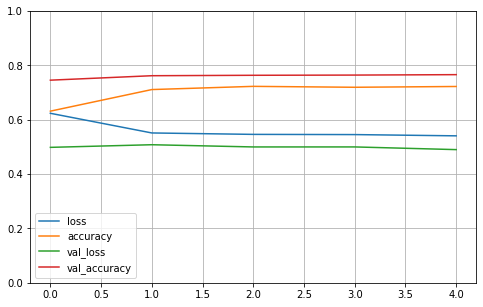

Compute valiation accuracy
2022-12-29 16:48:48.871672
Range of scores: 0.030008031 to 0.91170424
Predicted zeros and ones 855 426
Accuracy: 76.58% Precision: 66.67% Recall: 64.25% F1: 65.44%
2022-12-29 16:48:49.092019
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (4373, 3997) (4373, 1)
Valid sizes (1063, 3997) (1063, 1)
Train set ones/size 1730 / 4373
Valid set ones/size 427 / 1063
BUILD MODEL
COMPILE
FIT
2022-12-29 16:48:50.384457
Epoch 1/5
137/137 [==============================] - 2s 9ms/step - loss: 0.6182 - accuracy: 0.6462 - val_loss: 0.5551 - val_accuracy: 0.7093
Epoch 2/5
137/137 [==============================] - 1s 7ms/step - loss: 0.5369 - accuracy: 0.7247 - val_loss: 0.5541 - val_accuracy: 0.6990
Epoch 3/5
137/137 [==============================] - 1s 7ms/step - loss: 0.5320 - accuracy: 0.7281 - val_loss: 0.5465 - val_accuracy: 0.7187
Epoch 4/5
137/137 [==============================] - 1s 7ms/step - loss: 0.5287 - accuracy: 0.7350 - val_loss: 0.5448 - v

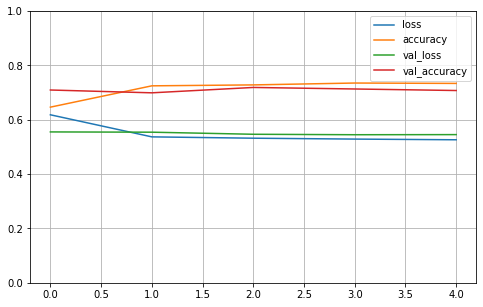

Compute valiation accuracy
2022-12-29 16:49:01.829423
Range of scores: 0.022702156 to 0.9243457
Predicted zeros and ones 691 372
Accuracy: 70.74% Precision: 65.59% Recall: 57.14% F1: 61.08%
2022-12-29 16:49:02.030612
Fold 5
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4434, 3997) (4434, 1)
Valid sizes (1002, 3997) (1002, 1)
Train set ones/size 1751 / 4434
Valid set ones/size 406 / 1002
BUILD MODEL
COMPILE
FIT
2022-12-29 16:49:03.349407
Epoch 1/5
139/139 [==============================] - 2s 9ms/step - loss: 0.6079 - accuracy: 0.6608 - val_loss: 0.5855 - val_accuracy: 0.6996
Epoch 2/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5312 - accuracy: 0.7260 - val_loss: 0.5794 - val_accuracy: 0.7096
Epoch 3/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5256 - accuracy: 0.7298 - val_loss: 0.5723 - val_accuracy: 0.7166
Epoch 4/5
139/139 [==============================] - 1s 7ms/step - loss: 0.5224 - accuracy: 0.7307 - val_loss: 0.5743 - va

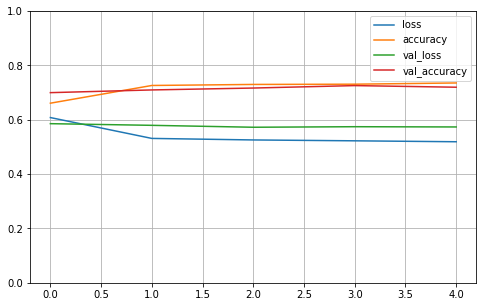

Compute valiation accuracy
2022-12-29 16:49:14.373602
Range of scores: 0.0328247 to 0.92121524
Predicted zeros and ones 557 445
Accuracy: 71.96% Precision: 64.04% Recall: 70.20% F1: 66.98%
2022-12-29 16:49:14.621169

Cross validation 5 folds 5 epochs
 accuracy mean 72.46% +/- 2.34
 precision mean 66.37% +/- 1.72
 recall mean 63.15% +/- 4.38
 F1 mean 64.62% +/- 2.22
2022-12-29 16:49:14.624113


In [295]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())